In [2]:
import glob
import pandas as pd
import numpy as np
import json

import pyecharts 
from collections import defaultdict

import matplotlib.pyplot as plt

import os
import re

# names

In [33]:
coco = json.load(open('./coco/annotations/instances_val2017.json'))
oid = pd.read_csv('./oid/annos/class-descriptions-boxable.csv', header=None)
obj365 = json.load(open('./obj365/annos/zhiyuan_objv2_val.json'))

In [34]:
def save_list(data, path):
    '''['person', 'bicycle', 'car',]
    '''
    with open(path, 'w') as f:
        f.write('\n'.join(data))

In [35]:
coco_names_map = {t['id']: t['name'].lower() for t in coco['categories'] }
coco_names = list(coco_names_map.values())

save_list(coco_names, 'analysis/coco_names.txt')
print(coco_names)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [36]:
oid_names = oid[1].tolist()
oid_names = [n.lower() for n in oid_names]
oid_names_map = dict(zip(oid[0].tolist(), oid_names))

save_list(oid_names, 'analysis/oid_names.txt')

# print(oid_names)

In [37]:
obj365_names_map = {t['id']: t['name'].lower() for t in obj365['categories'] }
obj365_names = list(obj365_names_map.values())
# print(obj365_names)

save_list(obj365_names, 'analysis/obj365_names')

In [38]:
print(len(coco_names), len(oid_names_map), len(obj365_names))

print( len(set(obj365_names).intersection(set(oid_names)).intersection(set(coco_names))) ) 

print( len( set(obj365_names).union(set(oid_names)).union(set(coco_names)) ) )

80 601 365
60
800


In [59]:
len(set(coco_names))

80

In [68]:
len(list(set(obj365_names).difference(set(coco_names))))

296

In [63]:
len( set(obj365_names).union(coco_names) )

376

In [70]:
list(set(oid_names) - set(obj365_names).union(coco_names))

['serving tray',
 'fax',
 'carnivore',
 'window blind',
 'swim cap',
 'doughnut',
 'tick',
 'human nose',
 'shelf',
 'measuring cup',
 'curtain',
 'snowman',
 'canary',
 'zucchini',
 'fashion accessory',
 'weapon',
 'accordion',
 'house',
 'dinosaur',
 'waffle iron',
 'pastry',
 'volleyball (ball)',
 'poster',
 'building',
 'wrench',
 'cooking spray',
 'human eye',
 'boot',
 'doll',
 'kitchen utensil',
 'lynx',
 'marine invertebrates',
 'envelope',
 'tart',
 'cabinetry',
 'bronze sculpture',
 'pressure cooker',
 'coat',
 'jacuzzi',
 'fruit',
 'aircraft',
 'harmonica',
 'beer',
 'caterpillar',
 'sewing machine',
 'dice',
 'christmas tree',
 'canoe',
 'skull',
 'scarf',
 'jaguar (animal)',
 'sword',
 'barrel',
 'ring binder',
 'cream',
 'sock',
 'golf cart',
 'tiara',
 'cocktail shaker',
 'squid',
 'porch',
 'paper cutter',
 'plumbing fixture',
 'drinking straw',
 'squirrel',
 'maple',
 'gondola',
 'container',
 'human mouth',
 'paper towel',
 'chest of drawers',
 'sea turtle',
 'trouser

# json2csv

In [42]:
def json_to_csv(path, label_map=None, dataset=None, normalized=True):
    '''json_to_csv
    '''
    data = json.load(open(path))
    image_map = {t['id']: t['file_name'] for t in data['images'] }
    
    print('annos: ', len(data['annotations']), )
    print('images: ', len(image_map))
    
    _data = pd.DataFrame()
    
    _files = [image_map[anno['image_id']] for anno in data['annotations']]
    if dataset == 'obj365':
        _files = [re.findall('(patch.+)', fstr)[0]  for fstr in _files]
        
    _files = ['/'.join([dataset, path.split('.')[-2].split('_')[-1], fstr]) for fstr in _files]
    # for _lin in _files:
    #     assert os.path.exists(_lin), f'{_lin}'
    _exists = [os.path.exists(fstr) for fstr in _files]
    
    _data['ImagePath'] = _files
    _data['LabelName'] = [label_map[anno['category_id']].lower() for anno in data['annotations']]
    
    # _data['Height'] = [image_height[anno['image_id']] for anno in data['annotations']]
    # _data['Width'] = [image_width[anno['image_id']] for anno in data['annotations']]
    
    _data['XMin'] = [anno['bbox'][0] for anno in data['annotations']]
    _data['YMin'] = [anno['bbox'][1] for anno in data['annotations']]
    _data['XMax'] = [anno['bbox'][0] + anno['bbox'][2] for anno in data['annotations']]
    _data['YMax'] = [anno['bbox'][1] + anno['bbox'][3] for anno in data['annotations']]
    _data['IsCrowd'] = [anno['iscrowd'] for anno in data['annotations']]
        
    if dataset == 'obj365':
        _data['IsfFake'] = [anno['isfake'] for anno in data['annotations']]
        
    if normalized:
        # TODO
        image_height = {t['id']: t['height'] for t in data['images'] }
        image_width = {t['id']: t['width'] for t in data['images'] }

        h = np.array([image_height[anno['image_id']] for anno in data['annotations']])
        w = np.array([image_width[anno['image_id']] for anno in data['annotations']])
        
        _data['XMin'] /= w
        _data['YMin'] /= h
        _data['XMax'] /= w
        _data['YMax'] /= h

    print('data: ', _data.shape)
    # _data = _data[_exists]
    print('after: ', _data.shape)
    
    _data.to_csv(path + '.csv')
    
    return _data

In [43]:
coco_train = json_to_csv('./coco/annotations/instances_train2017.json', coco_names_map, dataset='coco', normalized=True)

annos:  860001
images:  118287
data:  (860001, 7)
after:  (860001, 7)


In [44]:
coco_val = json_to_csv('./coco/annotations/instances_val2017.json', coco_names_map, dataset='coco', normalized=True)
coco_val[:2]

annos:  36781
images:  5000
data:  (36781, 7)
after:  (36781, 7)


,ImagePath,LabelName,XMin,YMin,XMax,YMax,IsCrowd
0,coco/val2017/000000289343.jpg,dog,0.894272,0.618641,0.967335,0.663438,0
1,coco/val2017/000000061471.jpg,dog,0.425156,0.417146,0.662609,1.000000,0


In [45]:
obj365_train = json_to_csv('./obj365/annos/zhiyuan_objv2_train.json', obj365_names_map, dataset='obj365', normalized=True)

annos:  25407633
images:  1742292
data:  (25407633, 8)
after:  (25407633, 8)


In [46]:
obj365_val = json_to_csv('./obj365/annos/zhiyuan_objv2_val.json', obj365_names_map, dataset='obj365', normalized=True)
obj365_val[:2]

annos:  1240587
images:  80000
data:  (1240587, 8)
after:  (1240587, 8)


,ImagePath,LabelName,XMin,YMin,XMax,YMax,IsCrowd,IsfFake
0,obj365/val/patch16/objects365_v2_00900010.jpg,slippers,0.053601,0.255461,0.074939,0.266648,0,0
1,obj365/val/patch16/objects365_v2_00900010.jpg,monkey,0.380102,0.445214,0.507573,0.552942,0,0


# json2txt

In [41]:
def json_to_txt(path, label_map=None, dataset='obj365'):
    '''json_to_txt
    '''
    data = json.load(open(path))
    image_map = {t['id']: t['file_name'] for t in data['images'] }
    image_height = {t['id']: t['height'] for t in data['images'] }
    image_width = {t['id']: t['width'] for t in data['images'] }
    
    output = defaultdict(str)
    
    for anno in data['annotations']:
        
        _id = anno['image_id']
        
        _h = image_height['image_id']
        _w = image_width['image_id']
        
        if _id not in output:
            if dataset == 'obj365':
                _file = re.findall('(patch.+)', image_map[anno['image_id']])[0]  
            elif dataset == 'coco':
                _file = image_map[anno['image_id']]

            _file = '/'.join([dataset, path.split('.')[-2].split('_')[-1], _file])
            output[_id] += _file
        
        else:
            output[_id] += ', '
            _name = label_map[anno['category_id']] 
            
            _xmin = f"{anno['bbox'][0]:.2f}"
            _ymin = f"{anno['bbox'][1]:.2f}" 
            _xmax = f"{anno['bbox'][0] + anno['bbox'][2]:.2f}"
            _ymax = f"{anno['bbox'][1] + anno['bbox'][3]:.2f}"
            output[_id] += '\t'.join([_name, _xmin, _ymin, _xmax, _ymax])
                
    with open(path + '.txt', 'w') as f:
        f.write('\n'.join([v for v in output.values()]))
        
    print(len(output))

In [42]:
# obj365_val = json_to_csv('./obj365/annos/zhiyuan_objv2_val.json', obj365_names_map)
json_to_txt('./obj365/annos/zhiyuan_objv2_val.json', obj365_names_map, dataset='obj365')
json_to_txt('./obj365/annos/zhiyuan_objv2_train.json', obj365_names_map, dataset='obj365')

80000
1742292


In [43]:
json_to_txt('./coco/annotations/instances_train2017.json', coco_names_map, dataset='coco')

117266


# csv

In [40]:
oid_train = pd.read_csv('./oid/annos/oidv6-train-annotations-bbox.csv')
print(len(oid_train))

14610229


In [29]:
groups = oid_train.groupby('ImageID')
print(len(groups))

1743042


In [30]:
oid_train[:3]

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,...,0,0,0.148438,0.012500,0.059375,0.195312,0.148438,0.357812,0.587500,0.325000
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,...,0,0,0.025000,0.248438,0.276563,0.214062,0.914062,0.714063,0.782813,0.948438
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,...,0,0,0.243750,0.151562,0.310937,0.262500,0.198437,0.434375,0.507812,0.590625


In [41]:
oid_train['ImagePath'] = oid_train['ImageID'].apply(lambda x: f'oid/full/train/{x}.jpg')
oid_train['LabelName'] = oid_train['LabelName'].apply(lambda x: oid_names_map[x].lower())
# _exists = [os.path.exists(fstr) for fstr in oid_train['ImagePath']]
# oid_train = oid_train[_exists]
print(oid_train.shape)

(14610229, 22)


In [104]:
oid_train_tmp = oid_train[['ImagePath', 'LabelName', 'XMin', 'YMin', 'XMax', 'YMax', 'IsOccluded', 'IsTruncated']]
oid_train_tmp.to_csv('./oid/annos/oidv6-train-annotations-bbox.csv' + '-tmp.csv')

In [101]:
print(oid_train_tmp.shape)
oid_train_tmp[:3]

(14610229, 8)


,ImagePath,LabelName,XMin,YMin,XMax,YMax,IsOccluded,IsTruncated
0,oid/full/image/000002b66c9c498e.jpg,person,0.012500,0.148438,0.195312,0.587500,0,1
1,oid/full/image/000002b66c9c498e.jpg,person,0.025000,0.714063,0.276563,0.948438,0,1
2,oid/full/image/000002b66c9c498e.jpg,person,0.151562,0.198437,0.310937,0.590625,1,0


In [ ]:
oid_val = pd.read_csv('./oid/annos/validation-annotations-bbox.csv')
print(oid_val.shape)
len(oid_val.groupby('ImageID'))

In [37]:
_counts = groups['ImageID'].value_counts().to_dict()
# save_list([' '.join([k[0], str(v)]) for k, v in _counts.items()], './analysis/oid_image_bboxes.txt')

In [40]:
# np.histogram(list(_counts.values()), bins=10)

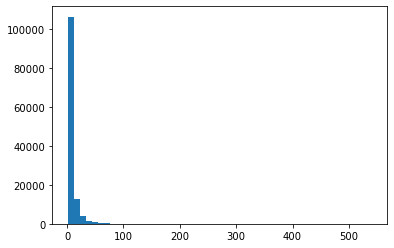

In [32]:
plt.hist(list(_counts.values()), bins=50)
plt.show()

# filter

In [24]:
eps = 1e-5
coco_train[(coco_train.XMax - coco_train.XMin > eps) & (coco_train.YMax - coco_train.YMin > eps)].shape

(859999, 7)

In [63]:
%%time

tmp_groups = coco_train.groupby('ImagePath')

for group in tmp_groups:
    print(group[0])
    print(group[1].shape)
    
    gt_bbox = np.array( group[1][['XMin', 'YMin', 'XMax', 'YMax']] )
    gt_class = group[1].LabelName.to_list()
    im_file = group[0]
    
    anno = {
        'im_file': im_file,
        'gt_bbox': gt_bbox,
        'gt_class': gt_class,
    }
    
    print(anno)
    
    break
    

def df_format(group):
    '''df_format'''
    gt_bbox = np.array( group[1][['XMin', 'YMin', 'XMax', 'YMax']] )
    gt_class = group[1].LabelName.to_list()
    im_file = group[0]
    
    anno = {
        'im_file': im_file,
        'gt_bbox': gt_bbox,
        'gt_class': gt_class,
    }
    return anno


tmp_groups = tmp_groups.apply(df_format).reset_index(name='anno')
tmp_groups[:2].anno.to_list()

coco/train2017/000000000009.jpg
(8, 7)
{'im_file': 'coco/train2017/000000000009.jpg', 'gt_bbox': array([[0.0016875 , 0.39102083, 0.95729688, 0.98652083],
       [0.48707813, 0.00897917, 0.98595312, 0.48539583],
       [0.39      , 0.47764583, 0.884125  , 0.98822917],
       [0.        , 0.02814583, 0.678875  , 0.80964583],
       [0.5878125 , 0.08408333, 0.70585937, 0.18102083],
       [0.72778125, 0.0811875 , 0.81851563, 0.17841667],
       [0.60265625, 0.15345833, 0.7339375 , 0.30035417],
       [0.56882813, 0.0051875 , 0.71689063, 0.15325   ]]), 'gt_class': ['bowl', 'bowl', 'broccoli', 'bowl', 'orange', 'orange', 'orange', 'orange']}
CPU times: user 53.7 s, sys: 2.09 s, total: 55.8 s
Wall time: 54.9 s


[{'im_file': 'coco/train2017/000000000009.jpg',
  'gt_bbox': array([[0.0016875 , 0.39102083, 0.95729688, 0.98652083],
         [0.48707813, 0.00897917, 0.98595312, 0.48539583],
         [0.39      , 0.47764583, 0.884125  , 0.98822917],
         [0.        , 0.02814583, 0.678875  , 0.80964583],
         [0.5878125 , 0.08408333, 0.70585937, 0.18102083],
         [0.72778125, 0.0811875 , 0.81851563, 0.17841667],
         [0.60265625, 0.15345833, 0.7339375 , 0.30035417],
         [0.56882813, 0.0051875 , 0.71689063, 0.15325   ]]),
  'gt_class': ['bowl',
   'bowl',
   'broccoli',
   'bowl',
   'orange',
   'orange',
   'orange',
   'orange']},
 {'im_file': 'coco/train2017/000000000009.jpg',
  'gt_bbox': array([[0.0016875 , 0.39102083, 0.95729688, 0.98652083],
         [0.48707813, 0.00897917, 0.98595312, 0.48539583],
         [0.39      , 0.47764583, 0.884125  , 0.98822917],
         [0.        , 0.02814583, 0.678875  , 0.80964583],
         [0.5878125 , 0.08408333, 0.70585937, 0.18102083],

# speed

In [96]:
def _parse(df):
    def _format(group):
        '''anno_format'''
        im_file = group.ImagePath.to_list()[0]
        # gt_bbox = group[['XMin', 'YMin', 'XMax', 'YMax']].to_numpy()
        gt_bbox = np.array([group[n].to_list() for n in ['XMin', 'YMin', 'XMax', 'YMax']] ).T
        # gt_bbox = [group[n].to_list() for n in ['XMin', 'YMin', 'XMax', 'YMax']]

        gt_class = group.LabelName.to_list()

        anno = {
            'im_file': im_file,
            'gt_bbox': gt_bbox,
            'gt_class': gt_class,
        }

        return anno

    eps = 1e-5
    data = df # pd.read_csv(path)            
    data = data[(data.XMax - data.XMin > eps) & (data.YMax - data.YMin > eps)]
    print(data.shape)
    # TODO
    data = data.groupby('ImagePath').apply(_format).reset_index(name='anno')

    return data.anno.to_list()

In [97]:
%time _test = _parse(coco_train[:100000])

(99999, 7)
CPU times: user 2.57 s, sys: 15.5 ms, total: 2.58 s
Wall time: 2.58 s


In [91]:
_test[0]['gt_bbox']

array([[0.02300885, 0.03554687, 0.97164602, 0.98815625],
       [0.00293805, 0.0051875 , 0.47833628, 0.43004688]])

In [51]:
m = oid_train[:10]['ImagePath'].apply(lambda x: os.path.exists(x))

In [52]:
oid_train[:10][m]

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y,ImagePath
0,000002b66c9c498e,xclick,person,1,0.012500,0.195312,0.148438,0.587500,0,1,...,0,0.148438,0.012500,0.059375,0.195312,0.148438,0.357812,0.587500,0.325000,oid/full/train/000002b66c9c498e.jpg
1,000002b66c9c498e,xclick,person,1,0.025000,0.276563,0.714063,0.948438,0,1,...,0,0.025000,0.248438,0.276563,0.214062,0.914062,0.714063,0.782813,0.948438,oid/full/train/000002b66c9c498e.jpg
2,000002b66c9c498e,xclick,person,1,0.151562,0.310937,0.198437,0.590625,1,0,...,0,0.243750,0.151562,0.310937,0.262500,0.198437,0.434375,0.507812,0.590625,oid/full/train/000002b66c9c498e.jpg
3,000002b66c9c498e,xclick,person,1,0.256250,0.429688,0.651563,0.925000,1,0,...,0,0.315625,0.429688,0.256250,0.423438,0.651563,0.921875,0.826562,0.925000,oid/full/train/000002b66c9c498e.jpg
4,000002b66c9c498e,xclick,person,1,0.257812,0.346875,0.235938,0.385938,1,0,...,0,0.317188,0.257812,0.346875,0.307812,0.235938,0.289062,0.348438,0.385938,oid/full/train/000002b66c9c498e.jpg
5,000002b66c9c498e,xclick,person,1,0.320312,0.368750,0.260938,0.328125,1,0,...,0,0.345313,0.320312,0.368750,0.353125,0.260938,0.298438,0.298438,0.328125,oid/full/train/000002b66c9c498e.jpg
6,000002b66c9c498e,xclick,person,1,0.412500,0.945312,0.120312,0.475000,1,0,...,0,0.412500,0.832812,0.945312,0.914062,0.323437,0.120312,0.250000,0.475000,oid/full/train/000002b66c9c498e.jpg
7,000002b66c9c498e,xclick,dairy product,1,0.528125,0.923437,0.675000,0.964063,0,0,...,0,0.709375,0.528125,0.671875,0.923437,0.675000,0.828125,0.964063,0.812500,oid/full/train/000002b66c9c498e.jpg
8,000002b66c9c498e,xclick,table,1,0.064062,0.492188,0.889063,0.993750,0,0,...,0,0.064062,0.492188,0.337500,0.398438,0.978125,0.948438,0.889063,0.993750,oid/full/train/000002b66c9c498e.jpg
9,000002b66c9c498e,xclick,table,1,0.301562,0.990625,0.462500,0.595312,0,0,...,0,0.301562,0.990625,0.932813,0.870313,0.492188,0.504687,0.462500,0.595312,oid/full/train/000002b66c9c498e.jpg
